Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_1416/3948104336.py:283: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Exact Match
1,9.679900,19.944106,28.042553


Epoch 1:
  - Train Loss = 25.66202077662691
  - Validation Loss = 19.944106101989746
  - EM Score = 28.04%


Epoch,Training Loss,Validation Loss,Exact Match
1,4.950400,7.596703,37.443888


Epoch 2:
  - Train Loss = 7.094560014440658
  - Validation Loss = 7.596703052520752
  - EM Score = 37.44%


Epoch,Training Loss,Validation Loss,Exact Match
1,4.204400,5.007810,42.653734


Epoch 3:
  - Train Loss = 4.429899256280128
  - Validation Loss = 5.0078104972839355
  - EM Score = 42.65%


Epoch,Training Loss,Validation Loss,Exact Match
1,3.688700,2.736527,46.962453


Epoch 4:
  - Train Loss = 3.3782902332062417
  - Validation Loss = 2.736527442932129
  - EM Score = 46.96%


Epoch,Training Loss,Validation Loss,Exact Match
1,3.343800,5.924998,45.420108


Epoch 5:
  - Train Loss = 2.7861504250384392
  - Validation Loss = 5.924997806549072
  - EM Score = 45.42%


Epoch,Training Loss,Validation Loss,Exact Match
1,2.986900,5.118136,46.254485


Epoch 6:
  - Train Loss = 2.4082697279909824
  - Validation Loss = 5.118136405944824
  - EM Score = 46.25%


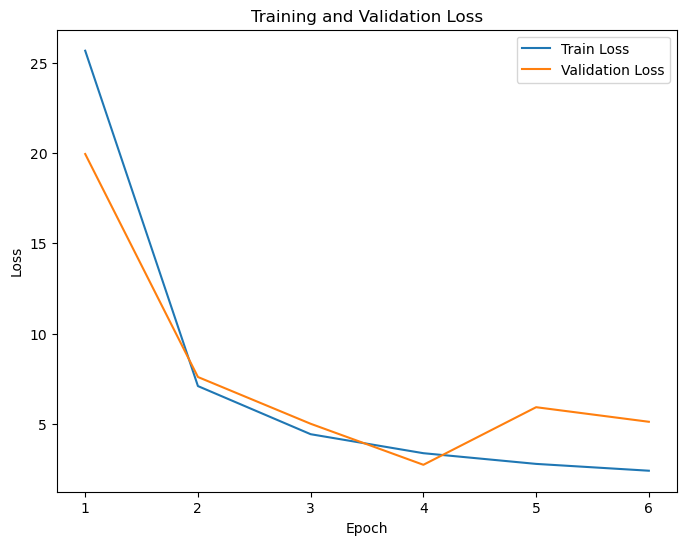

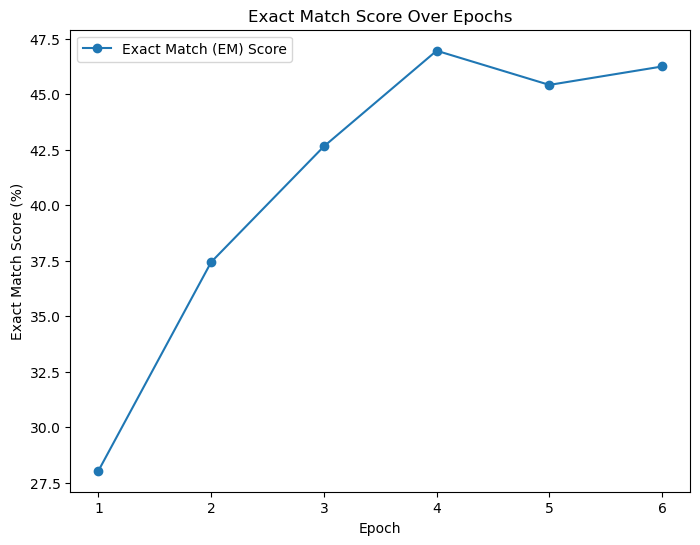

In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from torchcrf import CRF  # make sure to: pip install torchcrf
from datasets import load_dataset
import numpy as np
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm

# os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import os
os.environ["WANDB_DISABLED"] = "true"

def lowercase_example(example):
    example["question"] = example["question"].lower()
    example["context"] = example["context"].lower()
    example["answers"]["text"] = [ans.lower() for ans in example["answers"]["text"]]
    return example

def exact_match_score(predictions, references):
    """Compute the exact match score given predicted answer strings and a list of reference answers."""
    matches = 0
    for pred, ref_list in zip(predictions, references):
        if any(pred.strip() == ref.strip() for ref in ref_list):
            matches += 1
    return matches / len(references) * 100  # percentage

class SpanBERTCRFModel(nn.Module):
    def __init__(self, num_labels=3):
        super(SpanBERTCRFModel, self).__init__()
        self.bert = AutoModel.from_pretrained("SpanBERT/spanbert-base-cased")
        hidden_size = self.bert.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        sequence_output = outputs[0]  # (batch_size, seq_len, hidden_size)
        emissions = self.classifier(sequence_output)  # (batch_size, seq_len, num_labels)
        mask = attention_mask.bool() if attention_mask is not None else None

        # Always decode predictions
        decoded = self.crf.decode(emissions, mask=mask)
        decoded_tensors = []
        for seq in decoded:
            if len(seq) == 0:
                # Replace empty sequence with a default padded value.
                seq = [-100]
            decoded_tensors.append(torch.tensor(seq))
        padded_predictions = torch.nn.utils.rnn.pad_sequence(
            decoded_tensors, batch_first=True, padding_value=-100
        )
        
        if labels is not None:
            loss = -self.crf(emissions, labels, mask=mask, reduction='mean')
            return {"loss": loss, "predictions": padded_predictions}
        else:
            return {"predictions": padded_predictions, "dummy_loss": torch.tensor(0.0)}


def preprocess_validation_examples(example, tokenizer, max_length=512, doc_stride=128):
    inputs = tokenizer(
        example["question"],
        example["context"],
        max_length=max_length,
        truncation="only_second",
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []
    contexts = []
    answers_list = []
    label_sequences = []  # for validation we also compute BIO labels

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(example["id"][sample_idx])
        contexts.append(example["context"][sample_idx])
        answers_list.append(example["answers"][sample_idx])

        seq_ids = inputs.sequence_ids(i)
        offsets = inputs["offset_mapping"][i]
        labels = [0] * len(offsets)
        answer = example["answers"][sample_idx]
        if len(answer["answer_start"]) != 0:
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])
            idx = 0
            while idx < len(seq_ids) and seq_ids[idx] != 1:
                idx += 1
            context_start = idx
            while idx < len(seq_ids) and seq_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            if offsets[context_start][0] <= start_char and offsets[context_end][1] >= end_char:
                token_start, token_end = None, None
                for j in range(context_start, context_end + 1):
                    if offsets[j][0] <= start_char < offsets[j][1]:
                        token_start = j
                        break
                for j in range(context_end, context_start - 1, -1):
                    if offsets[j][0] < end_char <= offsets[j][1]:
                        token_end = j
                        break
                if token_start is not None and token_end is not None and token_start <= token_end:
                    labels[token_start] = 1
                    for k in range(token_start + 1, token_end + 1):
                        labels[k] = 2
        label_sequences.append(labels)
        # For evaluation later, we also set tokens outside context to None in the offset mapping.
        sequence_ids = inputs.sequence_ids(i)
        inputs["offset_mapping"][i] = [o if sequence_ids[k] == 1 else None for k, o in enumerate(offsets)]

    inputs["example_id"] = example_ids
    inputs["context"] = contexts
    inputs["answers"] = answers_list
    inputs["labels"] = label_sequences
    return inputs

##########################################
# Define the SpanBERT-CRF training class #
##########################################

class SpanBERTCRF:
    def __init__(self, max_length=512, doc_stride=128):
        self.dataset = load_dataset("squad_v2")
        # For demonstration purposes, we select a small subset.
        self.dataset["train"] = self.dataset["train"].select(range(15000))
        # self.dataset["validation"] = self.dataset["validation"].select(range(3500))
        self.dataset["train"] = self.dataset["train"].map(lowercase_example)
        self.dataset["validation"] = self.dataset["validation"].map(lowercase_example)
        self.validation_examples = self.dataset["validation"]

        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        self.model = SpanBERTCRFModel(num_labels=3)
        self.max_length = max_length
        self.doc_stride = doc_stride

    def preprocess_training_examples(self, examples):
        inputs = self.tokenizer(
            [q.strip().lower() for q in examples["question"]],
            [q.strip().lower() for q in examples["context"]],
            max_length=self.max_length,
            truncation="only_second",
            stride=self.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        offset_mapping = inputs.pop("offset_mapping")
        sample_map = inputs.pop("overflow_to_sample_mapping")
        answers = examples["answers"]
        all_labels = []

        for i, offset in enumerate(offset_mapping):
            sample_idx = sample_map[i]
            answer = answers[sample_idx]
            labels = [0] * self.max_length  # O by default

            if len(answer["answer_start"]) == 0:
                pass  # keep default positions for no-answer cases
            else:
                start_char = answer["answer_start"][0]
                end_char = answer["answer_start"][0] + len(answer["text"][0])
                sequence_ids = inputs.sequence_ids(i)

                idx = 0
                while sequence_ids[idx] != 1:
                    idx += 1
                context_start = idx
                while idx < len(sequence_ids) and sequence_ids[idx] == 1:
                    idx += 1
                context_end = idx - 1

                if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
                    pass
                else:
                    idx = context_start
                    while idx <= context_end and offset[idx][0] <= start_char:
                        idx += 1
                    start_pos = idx - 1

                    idx = context_end
                    while idx >= context_start and offset[idx][1] >= end_char:
                        idx -= 1
                    end_pos = idx + 1

                    # Generate BIO tags
                    if start_pos < self.max_length and end_pos < self.max_length and start_pos <= end_pos:
                        labels[start_pos] = 1  # B
                        for j in range(start_pos + 1, end_pos + 1):
                            if j < self.max_length:
                                labels[j] = 2  # I
            all_labels.append(labels)

        inputs["labels"] = all_labels
        return inputs

    def tokenize_dataset(self):
        train_dataset = self.dataset["train"].map(
            lambda ex: self.preprocess_training_examples(ex),
            batched=True,
            remove_columns=self.dataset["train"].column_names
        )
        validation_dataset = self.dataset["validation"].map(
            lambda ex: preprocess_validation_examples(ex, self.tokenizer, self.max_length, self.doc_stride),
            batched=True,
            remove_columns=self.dataset["validation"].column_names
        )
        # IMPORTANT: Do not remove the labels from validation dataset
        # so that the evaluation loss can be computed.
        # validation_dataset = validation_dataset.remove_columns(["labels"])

        # Save the validation features (with offset mapping, context, and answers)
        self.validation_features = validation_dataset
        return train_dataset, validation_dataset

    def compute_metrics(self, eval_pred):
        
        predictions, _ = eval_pred  # ignore label_ids if not provided
        if isinstance(predictions, np.ndarray):
            predictions = predictions.tolist()
        # print(predictions)
        pred_answers = []
        references = []
        
        # Iterate over each prediction and its corresponding original validation feature.
        for i, pred in enumerate(predictions):
            feature = self.validation_features[i]
            offsets = feature["offset_mapping"]  # list of (start, end) for tokens; tokens outside context are None
            context = feature["context"]
            
            start_token = None
            for j, tag in enumerate(pred):
                if offsets[j] is not None and tag in [1, 2]:
                    start_token = j
                    break
            if start_token is not None:
                end_token = start_token
                for j in range(start_token, len(pred)):
                    if offsets[j] is None or pred[j] not in [1, 2]:
                        break
                    end_token = j
                char_start = offsets[start_token][0]
                char_end = offsets[end_token][1]
                pred_answer = context[char_start:char_end].strip()
            else:
                pred_answer = ""
            
            pred_answers.append(pred_answer)
            references.append(feature["answers"]["text"])
        # print(pred_answers)
        em_score = exact_match_score(pred_answers, references)
        return {"eval_exact_match": em_score}

    def initialize_model(self, train_dataset, validation_dataset):
        training_args = TrainingArguments(
            output_dir="./results_crf",
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=4e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=1,
            warmup_steps=500,
            logging_steps=100,
            load_best_model_at_end=True,
            # Optionally, you can set a metric for best model selection:
            metric_for_best_model="eval_exact_match",
            greater_is_better=True,
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=validation_dataset,
            tokenizer=self.tokenizer,
            compute_metrics=self.compute_metrics,
        )
        return trainer

    def fit(self, trainer):
        train_losses = []
        em_scores = []
        val_losses = []

        # Training loop for multiple epochs
        for epoch in range(6):
            train_result = trainer.train()
            train_loss = train_result.metrics["train_loss"]
            train_losses.append(train_loss)

            eval_result = trainer.evaluate()
            # Extract validation loss and exact match score
            eval_loss = eval_result.get("eval_loss", None)
            em_score = eval_result.get("eval_exact_match", None)
            val_losses.append(eval_loss)
            em_scores.append(em_score)

            print(f"Epoch {epoch + 1}:")
            print(f"  - Train Loss = {train_loss}")
            print(f"  - Validation Loss = {eval_loss}")
            print(f"  - EM Score = {em_score:.2f}%")

        # Save the trained model
        trainer.save_model("./crf_model_checkpoint")

        # Plot training and validation loss
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.savefig("crf_loss.png")

        # Plot exact match scores
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(em_scores) + 1), em_scores, marker="o", label="Exact Match (EM) Score")
        plt.xlabel("Epoch")
        plt.ylabel("Exact Match Score (%)")
        plt.legend()
        plt.title("EM Score Over Epochs")
        plt.savefig("crf_em.png")

        return train_losses, em_scores, val_losses

# Instantiate, tokenize datasets, initialize model, and fit.
spanbert_crf = SpanBERTCRF()
train_dataset, validation_dataset = spanbert_crf.tokenize_dataset()
trainer = spanbert_crf.initialize_model(train_dataset, validation_dataset)
train_losses, em_scores, val_losses = spanbert_crf.fit(trainer)